In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import rankdata, norm
from itertools import combinations
import pandas as pd
from functools import lru_cache

In [2]:
# Adaptive precision summation algorithms
def fast_two_sum(a, b):
    """Fast two-sum algorithm with known abs(a) >= abs(b)."""
    x = a + b
    bv = x - a
    y = b - bv
    if y == 0:
        return x
    return x, y

In [3]:
def two_sum(a, b):
    """Two-sum algorithm with unknown order."""
    x = a + b
    bv = x - a
    av = x - bv
    br = b - bv
    ar = a - av
    y = ar + br
    if y == 0:
        return x
    return x, y

In [4]:
def expansion_sum(g):
    """Expansion sum algorithm."""
    g = sorted(g, key=abs)
    z = fast_two_sum(g[1], g[0])
    q = z[0]
    h = [z[1]] if len(z) > 1 else []
    n = len(g)
    if n == 2:
        return h + [q]
    for i in range(2, n):
        z = two_sum(q, g[i])
        q = z[0]
        if len(z) > 1:
            h.append(z[1])
    return h + [q]

In [5]:
# Hodges-Lehmann estimator of the median
def hlm(z):
    zz = np.add.outer(z, z)
    zz = zz[np.tril_indices(len(z), k=-1)]
    return np.median(zz) / 2

In [6]:
# JTK distribution calculation using the Harding algorithm
@lru_cache(None)
def jtkdist(timepoints, reps=None):
    if reps is None:
        reps = [1] * len(timepoints)
    n = sum(reps)
    comb = list(combinations(range(n), n // 2))
    ranks = np.array([sum(timepoints[i] for i in c) for c in comb])
    dist, counts = np.unique(ranks, return_counts=True)
    return dist, counts

In [15]:
# Main JTK algorithm
def runJTK(indata, JTKtime, minper=20, maxper=28):
    
    # Helper function to generate periodic templates
    def generate_templates(timepoints, minper, maxper):
        templates = []
        for period in range(minper, maxper + 1):
            t = np.linspace(0, 1, len(timepoints), endpoint=False)
            wave = np.sin(2 * np.pi * t * period)
            templates.append(wave)
        return templates


    # Normalize the input data
    def normalize_data(data):
        ranks = rankdata(data, method='average')
        return (ranks - np.mean(ranks)) / np.std(ranks)

    # Calculate JTK score
    def calculate_jtk_score(data, template):
        if data.ndim == 1:
            data = data.reshape(1, -1)
        scores = np.matmul(data, template.reshape(-1, 1))
        return np.max(scores), np.min(scores)


    # Load and normalize data
    data = pd.DataFrame(indata)
    normalized_data = data.apply(normalize_data, axis=0)

    # Generate periodic templates
    templates = generate_templates(JTKtime, minper, maxper)

    # Calculate null distribution
    null_dist_values, null_dist_counts = jtkdist(tuple(JTKtime), reps=None)

    # Calculate scores and p-values
    results = []
    for column in normalized_data.columns:
        series = normalized_data[column].values
        max_scores, min_scores = [], []
        for template in templates:
            max_score, min_score = calculate_jtk_score(series, template)
            max_scores.append(max_score)
            min_scores.append(min_score)

        max_score = max(max_scores)
        min_score = min(min_scores)

        # More accurate p-value calculation (right-tailed for max, left-tailed for min)
        max_pvalue = (np.sum(null_dist_counts[null_dist_values >= max_score]) + 1) / (np.sum(null_dist_counts) + 1)
        min_pvalue = (np.sum(null_dist_counts[null_dist_values <= min_score]) + 1) / (np.sum(null_dist_counts) + 1)

        results.append({
            'gene': column,
            'max_score': max_score,
            'min_score': min_score,
            'max_pvalue': max_pvalue,
            'min_pvalue': min_pvalue
        })

    return (pd.DataFrame(results), templates)

In [16]:
def generate_data(time_points):
    period = 24  
    amplitude = 2  
    phase_shift = np.random.uniform(0, period)
    data =  amplitude * np.sin(2 * np.pi * (np.array(time_points) - phase_shift) / period)
    data += np.random.normal(0, 0.5, len(data))
    return data

In [17]:
JTKtime = np.arange(0,24,2)

# Number of genes
num_genes = 1
data = pd.DataFrame(np.random.randn(len(JTKtime), num_genes), columns=[f"gene_{i+1}" for i in range(num_genes)])

# Add some circadian rhythm to a few genes
for i in range(1,num_genes):
    data[f'gene_{i}'] += generate_data(JTKtime)

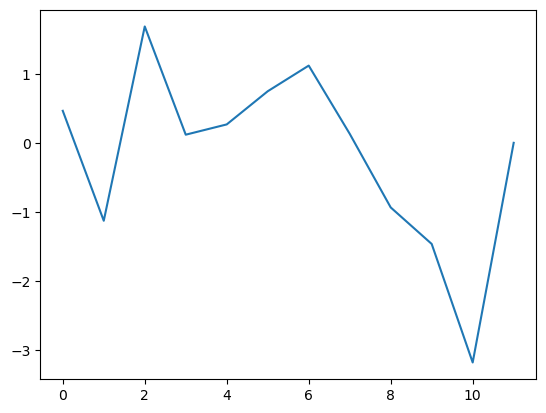

In [14]:
plt.plot(data)

In [18]:
result, templates = runJTK(data, JTKtime)

In [19]:
result

,gene,max_score,min_score,max_pvalue,min_pvalue
0,gene_1,5.723647,-5.723647,1.0,0.001081


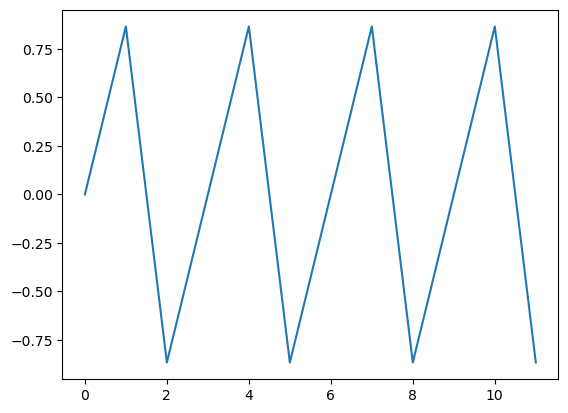

In [33]:
plt.plot(templates[8])